In [1]:
import dataframe_image as dfi
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import (GridSearchCV, cross_validate,
                                     train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from yellowbrick.features import rank1d
from yellowbrick.target import FeatureCorrelation
import numpy as np
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm

# The Dataset

Describe the dataset and the source: https://archive.ics.uci.edu/ml/datasets/Room+Occupancy+Estimation#

In [2]:
data = pd.read_csv('./Occupancy_Estimation.csv')
data.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


In [3]:
data.shape

(10129, 19)

# Data Cleaning

In [4]:
# let's check for nulls
data.isna().sum()

Date                    0
Time                    0
S1_Temp                 0
S2_Temp                 0
S3_Temp                 0
S4_Temp                 0
S1_Light                0
S2_Light                0
S3_Light                0
S4_Light                0
S1_Sound                0
S2_Sound                0
S3_Sound                0
S4_Sound                0
S5_CO2                  0
S5_CO2_Slope            0
S6_PIR                  0
S7_PIR                  0
Room_Occupancy_Count    0
dtype: int64

In [5]:
# let's check that the columns are appropriately typed
data.dtypes

Date                     object
Time                     object
S1_Temp                 float64
S2_Temp                 float64
S3_Temp                 float64
S4_Temp                 float64
S1_Light                  int64
S2_Light                  int64
S3_Light                  int64
S4_Light                  int64
S1_Sound                float64
S2_Sound                float64
S3_Sound                float64
S4_Sound                float64
S5_CO2                    int64
S5_CO2_Slope            float64
S6_PIR                    int64
S7_PIR                    int64
Room_Occupancy_Count      int64
dtype: object

In [6]:
# convert date and time fields to pandas datetime object
data.insert(2, 'datetime', pd.to_datetime(data['Date'] + ' ' + data['Time']))
data = data.iloc[:, 2:]
data.head()


,datetime,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017-12-22 10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017-12-22 10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017-12-22 10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017-12-22 10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017-12-22 10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


In [7]:
data.dtypes

datetime                datetime64[ns]
S1_Temp                        float64
S2_Temp                        float64
S3_Temp                        float64
S4_Temp                        float64
S1_Light                         int64
S2_Light                         int64
S3_Light                         int64
S4_Light                         int64
S1_Sound                       float64
S2_Sound                       float64
S3_Sound                       float64
S4_Sound                       float64
S5_CO2                           int64
S5_CO2_Slope                   float64
S6_PIR                           int64
S7_PIR                           int64
Room_Occupancy_Count             int64
dtype: object

# Data Exploration

In [8]:
data.apply([np.mean, np.std, min, max])

,datetime,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
mean,2017-12-27 20:27:23.034554112,25.454012,25.546059,25.056621,25.754125,25.445059,26.01629,34.248494,13.220259,0.168178,0.120066,0.158119,0.103840,460.860401,-0.004830,0.090137,0.079574,0.398559
std,7 days 05:02:05.971942454,0.351351,0.586325,0.427283,0.356434,51.011264,67.30417,58.400744,19.602219,0.316709,0.266503,0.413637,0.120683,199.964940,1.164990,0.286392,0.270645,0.893633
min,2017-12-22 10:49:41,24.940000,24.750000,24.440000,24.940000,0.000000,0.00000,0.000000,0.000000,0.060000,0.040000,0.040000,0.050000,345.000000,-6.296154,0.000000,0.000000,0.000000
max,2018-01-11 09:00:09,26.380000,29.000000,26.190000,26.560000,165.000000,258.00000,280.000000,74.000000,3.880000,3.440000,3.670000,3.400000,1270.000000,8.980769,1.000000,1.000000,3.000000


In [9]:
data.columns = data.columns.str.strip().str.lower()
X, y = (
    data.drop(["room_occupancy_count", "datetime"], axis=1),
    data["room_occupancy_count"]
)

/Users/i513604/Desktop/Personal/MSDS/22-Winter/COMP_4448_Tools_2/tools2_env/lib/python3.8/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


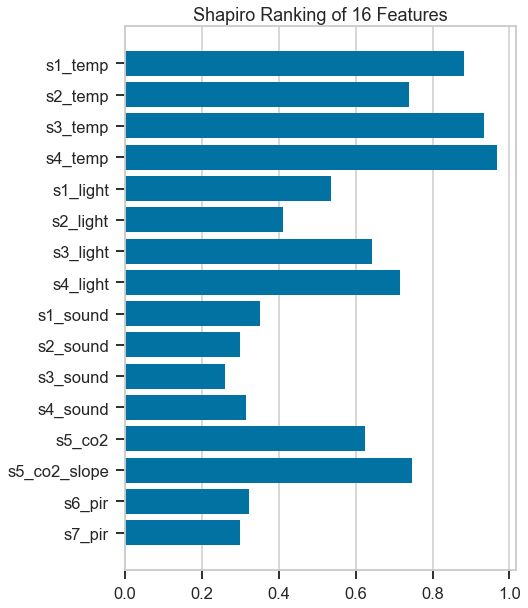

<AxesSubplot:title={'center':'Shapiro Ranking of 16 Features'}>

In [10]:
sns.set_context("talk")
plt.figure(figsize=(7, 10))
rank1d(X, y).show()

In [11]:
for i in data.columns[9:]:
    print(data[i].value_counts())

0.07    3833
0.08    3501
0.06     779
0.09     244
0.10      92
        ... 
2.79       1
2.49       1
3.51       1
2.59       1
3.16       1
Name: s1_sound, Length: 231, dtype: int64
0.05    5809
0.04    1426
0.06    1047
0.07     144
0.08      89
        ... 
2.12       1
1.78       1
3.13       1
2.25       1
2.54       1
Name: s2_sound, Length: 185, dtype: int64
0.06    5499
0.05    1398
0.07    1380
0.08     181
0.09      97
        ... 
2.92       1
1.24       1
2.34       1
0.79       1
2.24       1
Name: s3_sound, Length: 258, dtype: int64
0.06    2878
0.10    1914
0.09    1663
0.08     991
0.07     869
        ... 
1.36       1
1.35       1
1.84       1
0.87       1
1.80       1
Name: s4_sound, Length: 106, dtype: int64
355     2550
360     1391
345     1179
350      714
365      438
        ... 
1235       1
1090       1
1145       1
1130       1
1260       1
Name: s5_co2, Length: 186, dtype: int64
 0.000000    4495
-0.046154      84
-0.042308      63
-0.034615      53
-0.03

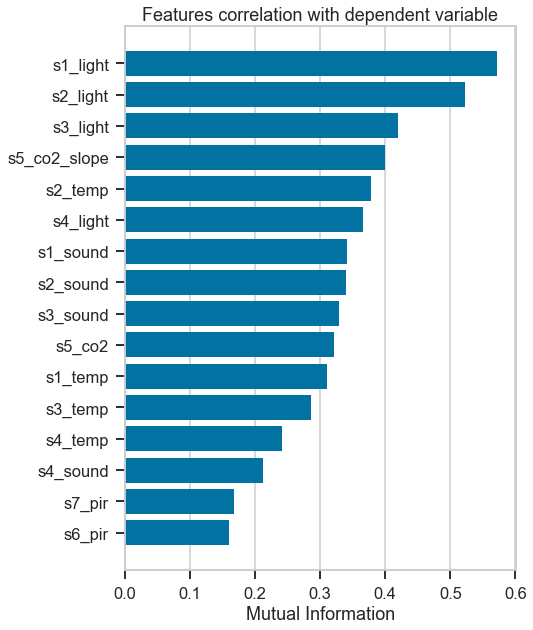

<AxesSubplot:title={'center':'Features correlation with dependent variable'}, xlabel='Mutual Information'>

In [12]:
visualizer = FeatureCorrelation(method="mutual_info-classification", sort=True)
plt.figure(figsize=(7, 10))
visualizer.fit(X, y)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

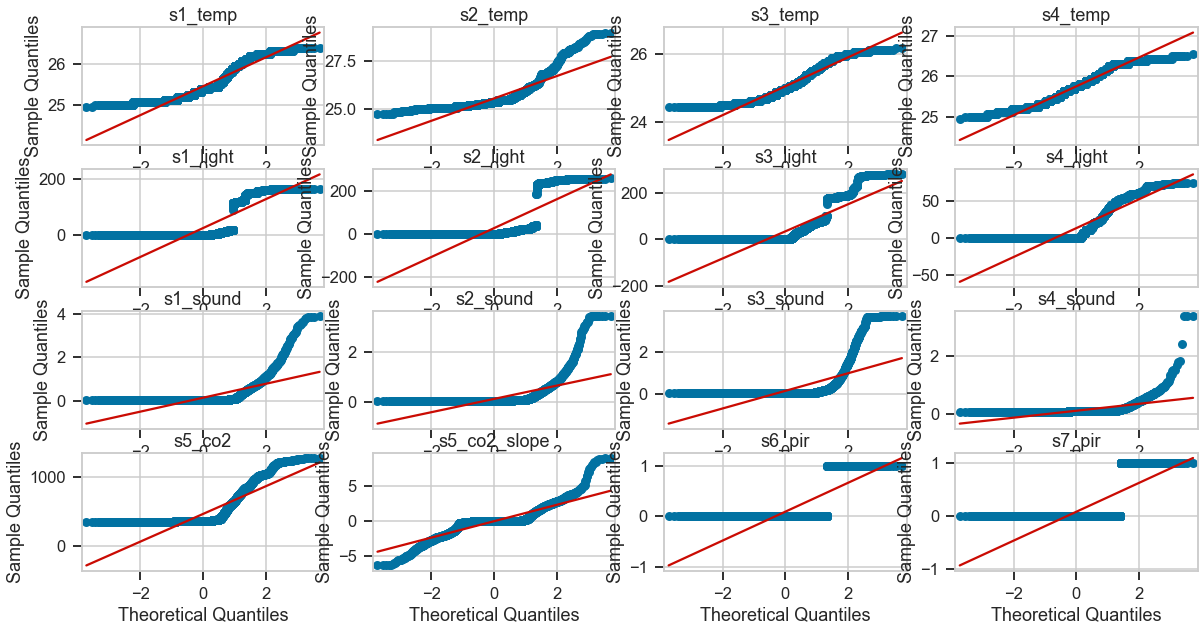

In [13]:
fig, ax = plt.subplots(4, 4, figsize=(20, 10))
ax = ax.flatten()
for i in range(1, 17):
    sm.qqplot(data.iloc[:, i], line='s', ax=ax[i - 1])
    ax[i - 1].set_title(data.columns[i])

Text(0.5, 0, 'Temperature')

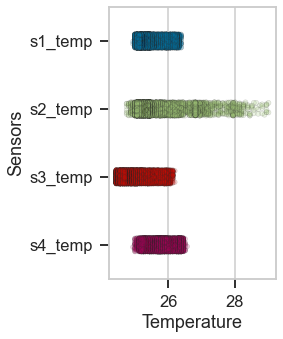

In [14]:
plt.figure(figsize=(3, 5))
sns.stripplot(
    data=data[[col for col in data.columns if "temp" in col]].melt(),
    alpha=0.2,
    linewidth=0.5,
    y="variable",
    x="value",
)

plt.ylabel("Sensors")
plt.xlabel("Temperature")

Text(0.5, 0, 'Light')

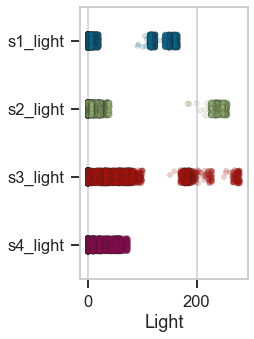

In [15]:
plt.figure(figsize=(3, 5))
sns.stripplot(
    data=data[[col for col in data.columns if "light" in col]].melt(),
    alpha=0.2,
    linewidth=0.5,
    y="variable",
    x="value",
)

plt.ylabel("")
plt.xlabel("Light")

Text(0.5, 0, 'sound')

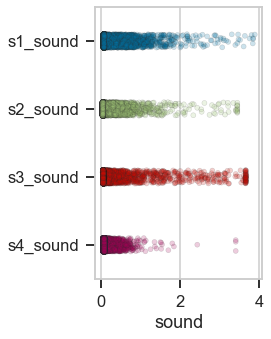

In [16]:
plt.figure(figsize=(3, 5))
sns.stripplot(
    data=data[[col for col in data.columns if "sound" in col]].melt(),
    alpha=0.2,
    linewidth=0.5,
    y="variable",
    x="value",
)

plt.ylabel("")
plt.xlabel("sound")

Text(0.5, 0, 'PIR')

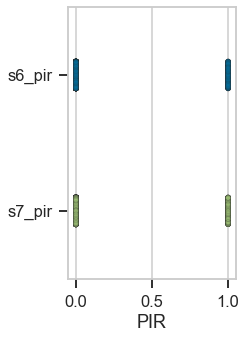

In [17]:
plt.figure(figsize=(3, 5))
sns.stripplot(
    data=data[
        [col for col in data.columns if "pir" in col and "slope" not in col]
    ].melt(),
    alpha=0.2,
    linewidth=0.5,
    y="variable",
    x="value",
)

plt.ylabel("")
plt.xlabel("PIR")

# Research Question

How does PCA affect the accuracy of various regression models when predicting the occupancy of a room? Which regression model is the best predictor of room occupancy out of Random Forest, Decision Tree, OLS Linear Regression, and Ridge Regression?

In [18]:
# the datetime variable is not relevant to our analysis here, so we will drop it
data = data.iloc[:, 1:]

# Data Partitioning

We want to use a 70-20-10 split for our training, validation, and test data, respectively.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=0.333333, random_state=42)

In [20]:
for dat, dat_name in [
    (X_train, "X_train"),
    (X_val, "X_validatation"),
    (X_test, "X_test"),
    (y_train, "y_train"),
    (y_val, "y_validation"),
    (y_test, "y_test")
]:
    print(dat_name)
    print(dat.shape[0])
    print(f"{dat.shape[0]/len(data):.0%} of data")
    print()

X_train
7090
70% of data

X_validatation
2027
20% of data

X_test
1012
10% of data

y_train
7090
70% of data

y_validation
2027
20% of data

y_test
1012
10% of data



Text(0, 0.5, 'Support')

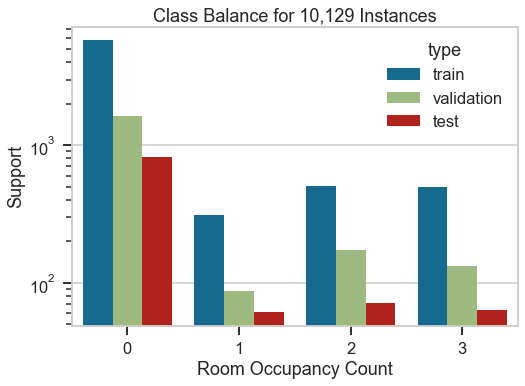

In [21]:
outcomes_df = pd.DataFrame()
for dat in [("train", y_train), ("validation", y_val), ("test", y_test)]:
    df = pd.DataFrame(dat[1].values)
    df["type"] = dat[0]
    outcomes_df = pd.concat([outcomes_df, df])
outcomes_df.rename(columns={0: "room_occupancy_count"}, inplace=True)
outcomes_df

sns.countplot(
    x="room_occupancy_count", y=None, hue="type", data=outcomes_df, order=None
)
plt.title("Class Balance for 10,129 Instances")
plt.yscale("log")
plt.xlabel("Room Occupancy Count")
plt.ylabel("Support")

# Model Construction and Selection

In [22]:
def transform_predictions(pred_array):
    """Transforms occupancy predictions into discrete values which match expected possible outcomes.
    Rounds predicted value to nearest integer unless predicted value is greater than 3. In which case, assigns 3.
    """
    new_preds = []
    for x in pred_array:
        if x < 0.5:
            new_preds.append(0)
        elif x < 1.5:
            new_preds.append(1)
        elif x < 2.5:
            new_preds.append(2)
        else:
            new_preds.append(3)
    return new_preds

In [23]:
models = [
    Ridge(),
    LinearRegression(),
    RandomForestRegressor(random_state=42),
    DecisionTreeRegressor(random_state=42),
]

In [24]:
data = [
    ("Train", X_train, y_train),
    ("Validation", X_val, y_val),
    ("Test", X_test, y_test),
]
results = []

In [25]:
for model in models:
    model_name = model.__class__.__name__
    model = Pipeline(
        [
            ("standardization", StandardScaler()),
            (model_name, model),
        ]
    )
    model.fit(X_train, y_train)
    print(model_name)
    for dat_name, x_dat, y_dat in data:
        results.append(
            [
                (
                    model_name,
                    "without_pca",
                    "RMSE",
                    dat_name,
                    mean_squared_error(
                        y_dat,
                        transform_predictions(model.predict(x_dat)),
                        squared=False,
                    ),
                )
            ]
        )
        results.append(
            [
                (
                    model_name,
                    "without_pca",
                    "R^2",
                    dat_name,
                    r2_score(y_dat, transform_predictions(model.predict(x_dat))),
                )
            ]
        )
    print("-" * 50)
    model_PCA = Pipeline(
        [
            ("standardization", StandardScaler()),
            ("pca", PCA(n_components=2)),
            (model_name, model),
        ]
    )
    model_PCA.fit(X_train, y_train)
    print(model_name, "with PCA (n components = 2)")
    for dat_name, x_dat, y_dat in data:
        results.append(
            [
                (
                    model_name,
                    "with_pca",
                    "RMSE",
                    dat_name,
                    mean_squared_error(
                        y_dat,
                        transform_predictions(model_PCA.predict(x_dat)),
                        squared=False,
                    ),
                )
            ]
        )
        results.append(
            [
                (
                    model_name,
                    "with_pca",
                    "R^2",
                    dat_name,
                    r2_score(y_dat, transform_predictions(model_PCA.predict(x_dat))),
                )
            ]
        )
    print("-" * 50)

Ridge
--------------------------------------------------
Ridge with PCA (n components = 2)
--------------------------------------------------
LinearRegression
--------------------------------------------------
LinearRegression with PCA (n components = 2)
--------------------------------------------------
RandomForestRegressor
--------------------------------------------------
RandomForestRegressor with PCA (n components = 2)
--------------------------------------------------
DecisionTreeRegressor
--------------------------------------------------
DecisionTreeRegressor with PCA (n components = 2)
--------------------------------------------------


In [26]:
results_df = pd.DataFrame(results)
results_df = pd.DataFrame(
    results_df[0].to_list(), columns=["model", "pca", "metric", "dataset", "value"]
)
results_df.head(10)

,model,pca,metric,dataset,value
0,Ridge,without_pca,RMSE,Train,0.279027
1,Ridge,without_pca,R^2,Train,0.903038
2,Ridge,without_pca,RMSE,Validation,0.292143
3,Ridge,without_pca,R^2,Validation,0.894157
4,Ridge,without_pca,RMSE,Test,0.286384
5,Ridge,without_pca,R^2,Test,0.890812
6,Ridge,with_pca,RMSE,Train,0.402741
7,Ridge,with_pca,R^2,Train,0.797995
8,Ridge,with_pca,RMSE,Validation,0.408953
9,Ridge,with_pca,R^2,Validation,0.792597


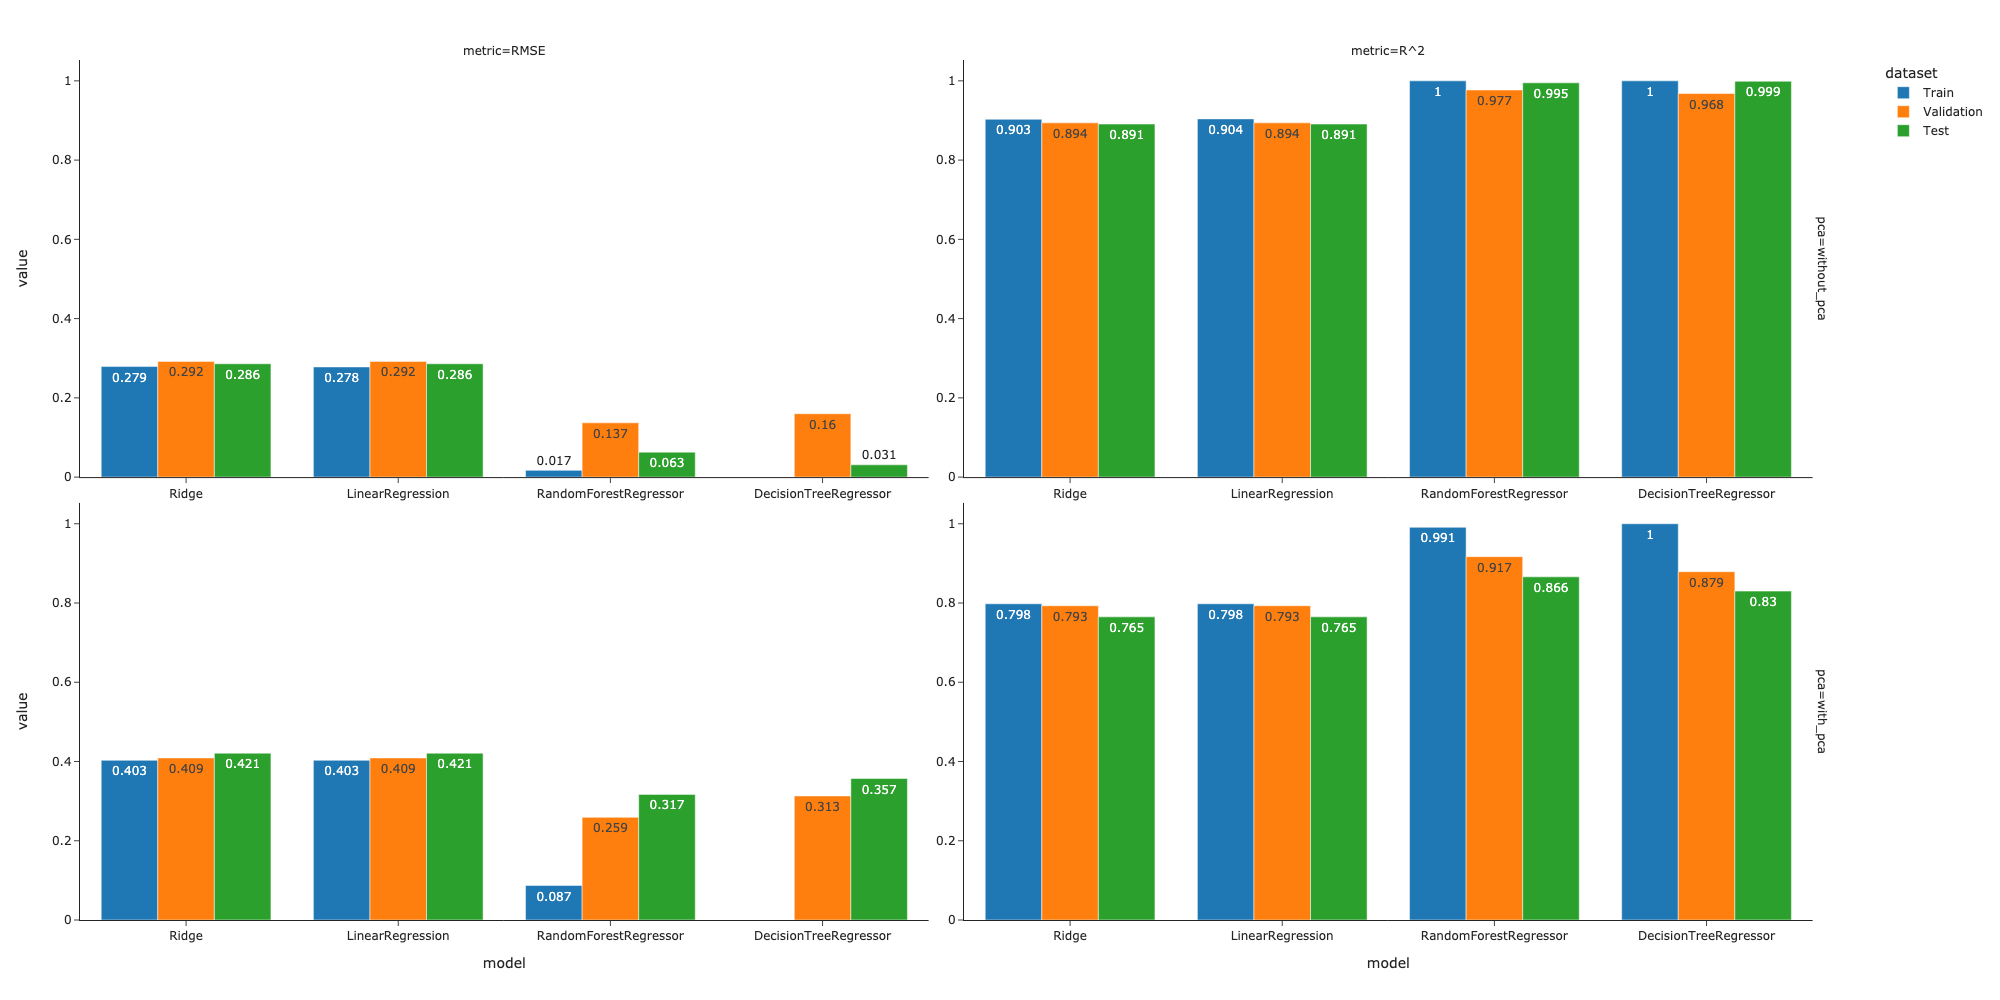

In [27]:
results_df["value"] = results_df["value"].round(3)
(
    px.bar(
        data_frame=results_df,
        x="model",
        y="value",
        color="dataset",
        facet_row="pca",
        facet_col="metric",
        facet_col_wrap=0,
        text="value",
        labels="value",
        barmode="group",
        template="simple_white",
        width=2000,
        height=1000,
    )
    .update_xaxes(showticklabels=True)
    .update_yaxes(showticklabels=True)
    .show(renderer="png")
)

In [28]:
results_df

,model,pca,metric,dataset,value
0,Ridge,without_pca,RMSE,Train,0.279
1,Ridge,without_pca,R^2,Train,0.903
2,Ridge,without_pca,RMSE,Validation,0.292
3,Ridge,without_pca,R^2,Validation,0.894
4,Ridge,without_pca,RMSE,Test,0.286
5,Ridge,without_pca,R^2,Test,0.891
6,Ridge,with_pca,RMSE,Train,0.403
7,Ridge,with_pca,R^2,Train,0.798
8,Ridge,with_pca,RMSE,Validation,0.409
9,Ridge,with_pca,R^2,Validation,0.793


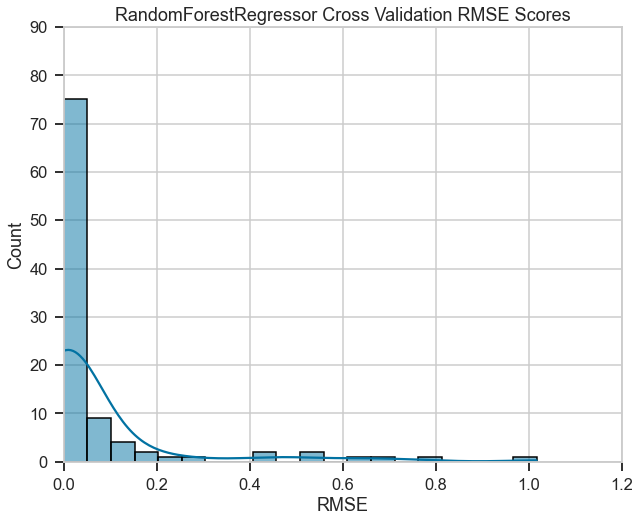

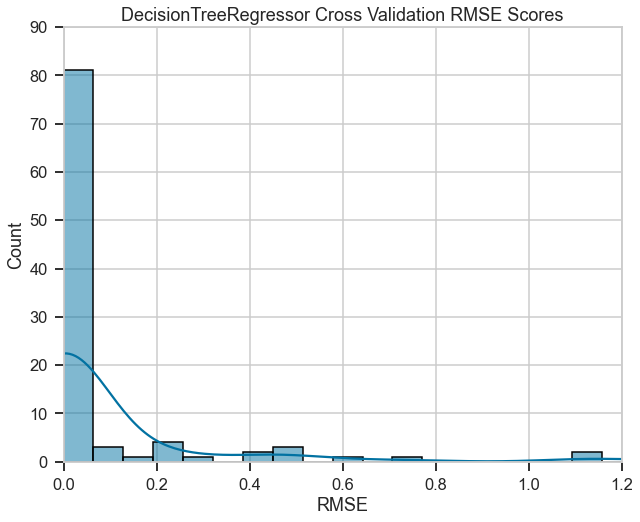

In [29]:
models = [
    RandomForestRegressor(max_depth=10),
    DecisionTreeRegressor(max_depth=10),
]

for model in models:
    scores = cross_validate(
        model, X, y, cv=100, scoring=("neg_mean_squared_error"), n_jobs=-1
    )["test_score"]
    scores *= -1
    scores **= 1 / 2

    plt.figure(figsize=(10, 8))
    sns.histplot(scores, bins=20, kde=True)
    plt.title(f"{model.__class__.__name__} Cross Validation RMSE Scores")
    plt.xlabel("RMSE")
    plt.xlim(0, 1.2)
    plt.ylim(0, 90)
    plt.show()

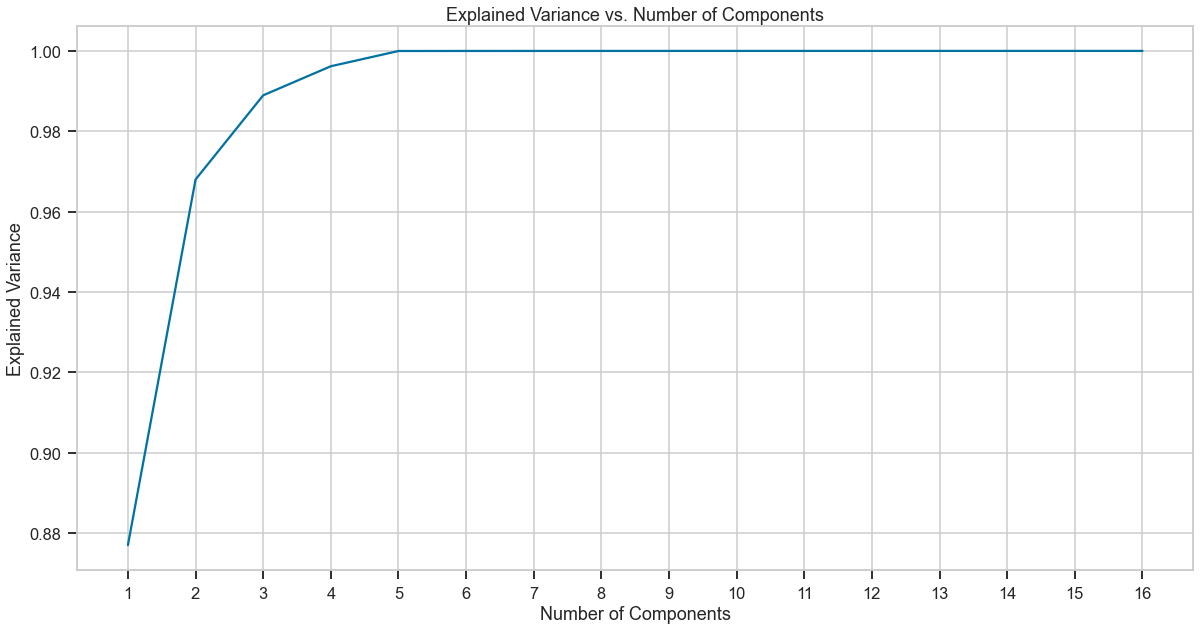

In [30]:
pca = PCA()
pca.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xticks(range(16), labels=range(1, 17))
plt.title("Explained Variance vs. Number of Components")
plt.ylabel("Explained Variance")
plt.xlabel("Number of Components")
plt.show()

In [31]:
pca_compare = results_df[results_df['dataset']=='Test'].set_index(['pca','model','metric'])['value'].to_frame().unstack(level=[0]).reset_index()
pca_compare['percent_difference'] = (pca_compare[('value','with_pca')] - pca_compare[('value','without_pca')]) * (100/abs(pca_compare[('value','with_pca')]))
pca_compare.columns = [c[0] if c[1] == '' else c[1] for c in pca_compare.columns.to_flat_index()]
pca_compare.set_index(['model','metric'], inplace=True)

pca_compare.unstack(level=1)

with_pca        without_pca        percent_difference  \
metric                    RMSE    R^2        RMSE    R^2               RMSE   
model                                                                         
DecisionTreeRegressor    0.357  0.830       0.031  0.999          91.316527   
LinearRegression         0.421  0.765       0.286  0.891          32.066508   
RandomForestRegressor    0.317  0.866       0.063  0.995          80.126183   
Ridge                    0.421  0.765       0.286  0.891          32.066508   

                                  
metric                       R^2  
model                             
DecisionTreeRegressor -20.361446  
LinearRegression      -16.470588  
RandomForestRegressor -14.896074  
Ridge                 -16.470588